# Bayes Classifier and Boosting

In [1]:
%matplotlib inline
%load_ext line_profiler
import numpy as np
from scipy import misc
from imp import reload
from labfuns import *
import random

## Bayes classifier functions

### Calculating model parameters

In [2]:
# NOTE: you do not need to handle the W argument for this part!
# in:      X - N x d matrix of N data points
#     labels - N vector of class labels
# out:    mu - C x d matrix of class means (mu[i] - class i mean)
#      sigma - C x d x d matrix of class covariances (sigma[i] - class i sigma)
def mlParams(X, labels, W=None):
    assert(X.shape[0]==labels.shape[0])
    Npts,Ndims = np.shape(X)
    classes = np.unique(labels)
    Nclasses = np.size(classes)

    W = None
    if W is None:
        W = np.ones((Npts,1))/float(Npts)

    mu = np.zeros((Nclasses,Ndims))
    sigma = np.zeros((Nclasses,Ndims,Ndims))

    for ci, c in enumerate(classes):
        idx = np.where(labels == c)
        wi = W.T[0][idx]
        for d in range(Ndims):
            xi = X.T[d][idx]
            mu[ci][d] = sum(wi*xi)/sum(wi)
            
    for ci, c in enumerate(classes):
        idx = np.where(labels == c)
        wi = W.T[0][idx]
        for d in range(Ndims):
            xi = X.T[d][idx]
            sigma[ci][d][d] = np.sum(wi*(xi - mu[ci][d])**2)/sum(wi)

    return mu, sigma

### Computing prior

In [3]:
# NOTE: you do not need to handle the W argument for this part!
# in: labels - N vector of class labels
# out: prior - C x 1 vector of class priors
def computePrior(labels, W=None):
    Npts = labels.shape[0]
    if W is None:
        W = np.ones((Npts,1))/Npts
    else:
        assert(W.shape[0] == Npts)
    classes = np.unique(labels)
    Nclasses = np.size(classes)

    prior = np.array([W[np.where(labels == c)].sum() for c in classes])
    prior /= prior.sum()+0.0001
    
    return prior

### Bayes classification

In [4]:
# in:      X - N x d matrix of M data points
#      prior - C x 1 matrix of class priors
#         mu - C x d matrix of class means (mu[i] - class i mean)
#      sigma - C x d x d matrix of class covariances (sigma[i] - class i sigma)
# out:     h - N vector of class predictions for test points
def classifyBayes(X, prior, mu, sigma):
    Npts = X.shape[0]
    Nclasses,Ndims = np.shape(mu)

    logProb = np.zeros((Nclasses, Npts))
    firsts = np.array([-0.5*np.log(np.linalg.det(sigma[ci])) for ci in range(0, Nclasses)])
    firsts += np.array([np.log(prior[ci]) for ci in range(0, Nclasses)])
    mids = np.array([1.0/np.diag(sigma[ci]) for ci in range(0, Nclasses)])
    
    for ci in range(Nclasses):
        for pt in range(Npts):
            logProb[ci][pt] += firsts[ci]
            logProb[ci][pt] += -0.5*(X[pt]-mu[ci])*mids[ci]@(X[pt]-mu[ci]).T
    
    # one possible way of finding max a-posteriori once
    # you have computed the log posterior
    h = np.argmax(logProb, axis=0)
    return h

class BayesClassifier(object):
    def __init__(self):
        self.trained = False

    def trainClassifier(self, X, labels, W=None):
        rtn = BayesClassifier()
        rtn.prior = computePrior(labels, W)
        rtn.mu, rtn.sigma = mlParams(X, labels, W)
        rtn.trained = True
        return rtn

    def classify(self, X):
        return classifyBayes(X, self.prior, self.mu, self.sigma)

## Maximum Likelihood estimates

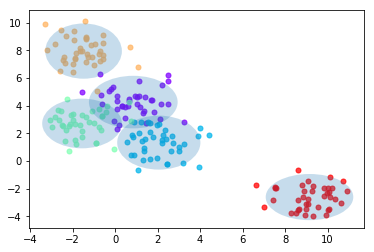

In [77]:
%matplotlib inline

X, labels = genBlobs(centers=5)
mu, sigma = mlParams(X,labels)
plotGaussian(X,labels,mu,sigma)

## Testing the performance of classifiers

In [228]:
testClassifier(BayesClassifier(), dataset='iris', split=0.7)

Trial: 0 Accuracy 84.4
Trial: 10 Accuracy 95.6
Trial: 20 Accuracy 93.3
Trial: 30 Accuracy 86.7
Trial: 40 Accuracy 88.9
Trial: 50 Accuracy 91.1
Trial: 60 Accuracy 86.7
Trial: 70 Accuracy 91.1
Trial: 80 Accuracy 86.7
Trial: 90 Accuracy 91.1
Final mean classification accuracy  89 with standard deviation 4.16


### The accuracy is reasonably high

In [230]:
testClassifier(BayesClassifier(), dataset='vowel', split=0.7)

Trial: 0 Accuracy 61
Trial: 10 Accuracy 66.2
Trial: 20 Accuracy 74
Trial: 30 Accuracy 66.9
Trial: 40 Accuracy 59.7
Trial: 50 Accuracy 64.3
Trial: 60 Accuracy 66.9
Trial: 70 Accuracy 63.6
Trial: 80 Accuracy 62.3
Trial: 90 Accuracy 70.8
Final mean classification accuracy  64.7 with standard deviation 4.03


### The accuracy is quite low

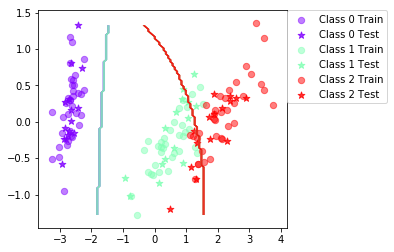

In [231]:
plotBoundary(BayesClassifier(), dataset='iris',split=0.7)

## Questions/Answers

*(1) When can a feature independence assumption be reasonable and when not?*

**Feature independence is reasonable to assume when there is low correlation between the two features**

*(2) How does the decision boundary look for the Iris dataset? How could one improve the classification results for this scenario by changing classifier or, alternatively, manipulating the data?*

**The decisions boundaries look quite accurate except between class 2 and 1 in a specific region.**

**Classification can be improved by using a decision tree (may suit better the data) OR by focusing learning in ambiguous boundary region (high error should have higher density).**

## Boosting functions to implement

In [5]:
# in: base_classifier - a classifier of the type that we will boost, e.g. BayesClassifier
#                   X - N x d matrix of N data points
#              labels - N vector of class labels
#                   T - number of boosting iterations
# out:    classifiers - (maximum) length T Python list of trained classifiers
#              alphas - (maximum) length T Python list of vote weights
def trainBoost(base_classifier, X, labels, T=10):
    # these will come in handy later on
    Npts,Ndims = np.shape(X)

    classifiers = [] # append new classifiers to this list
    alphas = [] # append the vote weight of the classifiers to this list

    # The weights for the first iteration
    wCur = np.ones((Npts,1))/float(Npts)

    for i_iter in range(0, T):
        # a new classifier can be trained like this, given the current weights
        classifiers.append(base_classifier.trainClassifier(X, labels, wCur))
        
        # do classification for each point
        vote = classifiers[-1].classify(X)
        lamb = np.vectorize(lambda x, y: 1 if x == y else 0)
        error = (wCur.T[0]*(1-lamb(vote, labels))).sum()
        alpha = 0.5*(np.log(1-error) - np.log(error))
        newCur = np.exp(-alpha) * wCur.reshape(Npts,) * (vote == labels).astype(int)
        newCur += np.exp(alpha) * wCur.reshape(Npts,) * (vote != labels).astype(int)
        wCur = newCur.reshape((Npts, 1))/newCur.sum()
        
        alphas.append(alpha)
        
    return classifiers, alphas

# in:       X - N x d matrix of N data points
# classifiers - (maximum) length T Python list of trained classifiers as above
#      alphas - (maximum) length T Python list of vote weights
#    Nclasses - the number of different classes
# out:  yPred - N vector of class predictions for test points
def classifyBoost(X, classifiers, alphas, Nclasses):
    Npts = X.shape[0]
    Ncomps = len(classifiers)
    # if we only have one classifier, we may just classify directly
    if Ncomps == 1:
        return classifiers[0].classify(X)
    else:
        votes = np.zeros((Npts, Nclasses))
    # Filling votes
    lamb = np.vectorize(lambda x, y: 1 if x == y else 0)
    for c in range(0, Nclasses):
        votes.T[c] = np.array([al*lamb(cl.classify(X), c) for al,cl in zip(alphas, classifiers)]).sum(axis=0)
    # Returning best candidate
    return np.argmax(votes, axis=1)

The implemented functions can now be summarized another classifer, the `BoostClassifier` class. This class enables boosting different types of classifiers by initializing it with the `base_classifier` argument. No need to add anything here.

In [6]:
# NOTE: no need to touch this
class BoostClassifier(object):
    def __init__(self, base_classifier, T=10):
        self.base_classifier = base_classifier
        self.T = T
        self.trained = False

    def trainClassifier(self, X, labels):
        rtn = BoostClassifier(self.base_classifier, self.T)
        rtn.nbr_classes = np.size(np.unique(labels))
        rtn.classifiers, rtn.alphas = trainBoost(self.base_classifier, X, labels, self.T)
        rtn.trained = True
        return rtn

    def classify(self, X):
        return classifyBoost(X, self.classifiers, self.alphas, self.nbr_classes)

## Run some experiments

Call the `testClassifier` and `plotBoundary` functions for this part.

In [255]:
testClassifier(BoostClassifier(BayesClassifier(), T=10), dataset='iris',split=0.7)

Trial: 0 Accuracy 84.4
Trial: 10 Accuracy 95.6
Trial: 20 Accuracy 93.3
Trial: 30 Accuracy 86.7
Trial: 40 Accuracy 88.9
Trial: 50 Accuracy 91.1
Trial: 60 Accuracy 86.7
Trial: 70 Accuracy 91.1
Trial: 80 Accuracy 86.7
Trial: 90 Accuracy 91.1
Final mean classification accuracy  89 with standard deviation 4.16


In [236]:
testClassifier(BoostClassifier(BayesClassifier(), T=10), dataset='vowel',split=0.7)

Trial: 0 Accuracy 61
Trial: 10 Accuracy 66.2
Trial: 20 Accuracy 74
Trial: 30 Accuracy 66.9
Trial: 40 Accuracy 59.7
Trial: 50 Accuracy 64.3
Trial: 60 Accuracy 66.9
Trial: 70 Accuracy 63.6
Trial: 80 Accuracy 62.3
Trial: 90 Accuracy 70.8
Final mean classification accuracy  64.7 with standard deviation 4.03


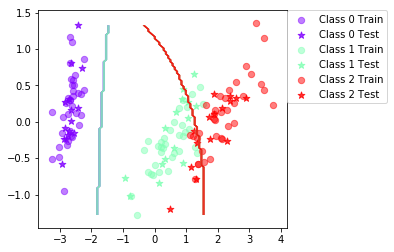

In [8]:
plotBoundary(BoostClassifier(BayesClassifier(), T=10), dataset='iris',split=0.7)

## Questions/Answers

*1) Is there any improvement in classification accuracy? Why/why not?*

**There is no improvement in classification accuracy. Boosting may only work for weak classifiers, and that one was already strong.**

*2) Plot the decision boundary of the boosted classifier on iris and compare it with that of the basic. What differences do you notice? Is the boundary of the boosted version more complex?

**No major differences. No it is not.**

*3) Can we make up for not using a more advanced model in the basic classifier (e.g. independent features) by using boosting?*

**No, we still need to have an advanced model, as boosting only improves from the classification already computed.**

Now repeat the steps with a decision tree classifier.

In [257]:
testClassifier(DecisionTreeClassifier(), dataset='iris', split=0.7)

Trial: 0 Accuracy 95.6
Trial: 10 Accuracy 100
Trial: 20 Accuracy 91.1
Trial: 30 Accuracy 91.1
Trial: 40 Accuracy 93.3
Trial: 50 Accuracy 91.1
Trial: 60 Accuracy 88.9
Trial: 70 Accuracy 88.9
Trial: 80 Accuracy 93.3
Trial: 90 Accuracy 88.9
Final mean classification accuracy  92.4 with standard deviation 3.71


In [258]:
testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='iris',split=0.7)

Trial: 0 Accuracy 95.6
Trial: 10 Accuracy 100
Trial: 20 Accuracy 95.6
Trial: 30 Accuracy 93.3
Trial: 40 Accuracy 93.3
Trial: 50 Accuracy 95.6
Trial: 60 Accuracy 88.9
Trial: 70 Accuracy 93.3
Trial: 80 Accuracy 93.3
Trial: 90 Accuracy 93.3
Final mean classification accuracy  94.6 with standard deviation 3.65


In [259]:
testClassifier(DecisionTreeClassifier(), dataset='vowel',split=0.7)

Trial: 0 Accuracy 63.6
Trial: 10 Accuracy 68.8
Trial: 20 Accuracy 63.6
Trial: 30 Accuracy 66.9
Trial: 40 Accuracy 59.7
Trial: 50 Accuracy 63
Trial: 60 Accuracy 59.7
Trial: 70 Accuracy 68.8
Trial: 80 Accuracy 59.7
Trial: 90 Accuracy 68.2
Final mean classification accuracy  64.1 with standard deviation 4


In [260]:
testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='vowel',split=0.7)

Trial: 0 Accuracy 85.7
Trial: 10 Accuracy 89.6
Trial: 20 Accuracy 86.4
Trial: 30 Accuracy 93.5
Trial: 40 Accuracy 83.8
Trial: 50 Accuracy 79.2
Trial: 60 Accuracy 90.3
Trial: 70 Accuracy 85.7
Trial: 80 Accuracy 85.1
Trial: 90 Accuracy 86.4
Final mean classification accuracy  86.9 with standard deviation 3.08


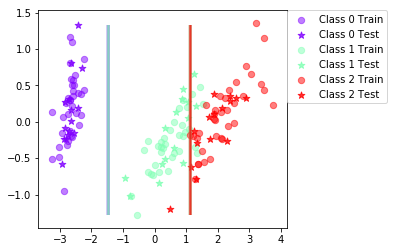

In [261]:
%matplotlib inline
plotBoundary(DecisionTreeClassifier(), dataset='iris',split=0.7)

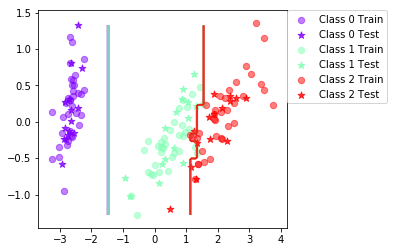

In [262]:
%matplotlib inline
plotBoundary(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='iris',split=0.7)

## Questions/Answers

*1) Is there any improvement in classification accuracy? Why/why not?*

**There is significant improvement in classification accuracy. Boosting work really well with Decision Trees as it tends to multiply branches in areas where error is strong.**

*2) Plot the decision boundary of the boosted classifier on iris and compare it with that of the basic. What differences do you notice? Is the boundary of the boosted version more complex?

**Big difference as we see the boundary getting more accurate near the highest-error region**

*3) Can we make up for not using a more advanced model in the basic classifier (e.g. independent features) by using boosting?*

**(Same answer).**

## Conclusion

I would choose a boosted Decision tree because:
* **Outliers**: It's not too biased for outliers
* **Irrelevant inputs**: It can easily ignore irrelevant features (contrary to Bayes)
* **Predictive power**: Simple but powerful
* **Mixed types of data**: Plays well with mixed data, as labels can be anything (Bayes works better for continuous)
* **Scalability**: Scales better when data points are large but dimensions are small.

## Bonus: Visualize faces classified using boosted decision trees

Note that this part of the assignment is completely voluntary! First, let's check how a boosted decision tree classifier performs on the olivetti data. Note that we need to reduce the dimension a bit using PCA, as the original dimension of the image vectors is `64 x 64 = 4096` elements.

In [327]:
testClassifier(BayesClassifier(), dataset='olivetti', split=0.7, dim=20)

Trial: 0 Accuracy 88.3
Trial: 10 Accuracy 90.8
Trial: 20 Accuracy 85
Trial: 30 Accuracy 89.2
Trial: 40 Accuracy 89.2
Trial: 50 Accuracy 84.2
Trial: 60 Accuracy 91.7
Trial: 70 Accuracy 82.5
Trial: 80 Accuracy 81.7
Trial: 90 Accuracy 86.7
Final mean classification accuracy  87.7 with standard deviation 3.03


In [295]:
testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='olivetti', split=0.7, dim=20)

Trial: 0 Accuracy 73.3
Trial: 10 Accuracy 70
Trial: 20 Accuracy 79.2
Trial: 30 Accuracy 74.2
Trial: 40 Accuracy 71.7
Trial: 50 Accuracy 70.8
Trial: 60 Accuracy 77.5
Trial: 70 Accuracy 50
Trial: 80 Accuracy 71.7
Trial: 90 Accuracy 68.3
Final mean classification accuracy  70.2 with standard deviation 6.93


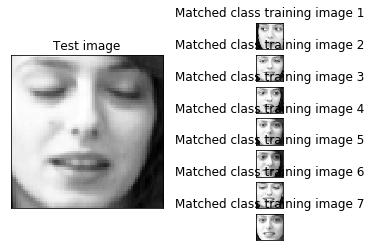

In [7]:
X,y,pcadim = fetchDataset('olivetti') # fetch the olivetti data
xTr,yTr,xTe,yTe,trIdx,teIdx = trteSplitEven(X,y,0.7) # split into training and testing
pca = decomposition.PCA(n_components=20) # use PCA to reduce the dimension to 20
hide = pca.fit(xTr) # use training data to fit the transform
xTrpca = pca.transform(xTr) # apply on training data
xTepca = pca.transform(xTe) # apply on test data
# use our pre-defined decision tree classifier together with the implemented
# boosting to classify data points in the training data
classifier = BoostClassifier(DecisionTreeClassifier(), T=10).trainClassifier(xTrpca, yTr)
yPr = classifier.classify(xTepca)
# choose a test point to visualize
testind = random.randint(0, xTe.shape[0]-1)
# visualize the test point together with the training points used to train
# the class that the test point was classified to belong to
visualizeOlivettiVectors(xTr[yTr == yPr[testind],:], xTe[testind,:])